In [ ]:
pip install openseespy opsvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 468.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 11.2 MB/s eta 0:00:00


In [ ]:
import openseespy.opensees as ops
import opsvis as opsv
import os
import matplotlib.pyplot as plt

In [ ]:
ops.wipe()
DataDir = r'Output'
if not os.path.exists(DataDir):
  os.makedirs(DataDir)

In [ ]:

# Creating 2D Model
ops.model('Basic', '-ndm', 2, '-ndf', 3)

# Defining problem
numBay = 1
numFloor = 1

#1ft = 12 inch = 30cm

#Parameters
L = 30.0 #baywidth(in ft)
H = 18.0 #storey-height (in ft)
H2 = 14.0 #storey-height - vertical truss element
l = 5.5 #horizontal truss element length
Lc = 8 #Chord member length
h = 4.0 #vertical member height

F = 10.0 #no idea of units and earthquake's values

#1 GPa = 145.038 ksi
#Total Building Weight, W = 19839 kips
#Total 10 stories and 5 bays, thus single structure weight:
#w = 19839/50 = 396.78 kips
#1 kip = 453.6 kg

#Material properties(steel)
E = 29007.6 #ksi(200 X 145.038)
lm = 396.78 #lumped mass(in kips)
Fy = 50.0 #ksi(assumed)

#For column(W30X292 section)
A_col = 86 #in^sq
Ix = 14900 #in^4
Iy = 1100 #in^4

#Now, all double channels, thus area doubled, also MOI in case of
#vertical channels gets simply doubled and in case of chords re-calculated.

#For chord-2 (C10 X 30 x 1.5 in plate)
A0 = 31.495 #in^2
I2 = 132.18 #in^4

#For vertical-1 (MC6X16.3)
A1 = 9.58 #in^2
Iv = 52.0 #in^4

#For diagonals (MC10X25)
A2 = 14.68 #in^2
Id = 117.25

#For chord-1(truss), vertical-SS(truss), and chord-SS(I-Section) {C10 X 30}
A = 17.62 #in^2
I1 = 34.52 #in^4 (About minor axis for chords)
Ivs = 206.0 #in^4 (About major axis for the vertical member)

# Defining Transformation for beam-column elements
#ops.geomTransf('Linear', 1)
ops.geomTransf('PDelta', 1)

#storing coordinates in an array:
#coords = [
#    (10,0,0), (20,L,0),
#    (11,0,H), (21,L,H),
#    (110,0,H2), (210,L,H2),
#    (111,l,H2), (112,2*l,H2),(113,2*l + Lc,H2), (114,L - l, H2),
#    (115,l,H), (116,2*l,H),(117,2*l + Lc,H), (118,L - l, H),

#]

coords = [
   (10,0,0), (20,L,0),  (11,0,H), (21,L,H),(110,0,H2), (210,L,H2),
   (111,l,H2), (112,2*l,H2),(113,2*l + Lc,H2), (114,L - l, H2),
   (115,l,H), (116,2*l,H),(117,2*l + Lc,H), (118,L - l, H),
   (30,2*L,0), (31,2*L,H)
]
#generating node
for tag, x, y in coords:
    ops.node(tag, x, y)

#Boundary conditions
for i in [10,20,30]:
  ops.fix(i,1,1,0)

#Defining material(for truss elements)
ops.uniaxialMaterial('Elastic', 1, E)

#Defining all the elements('truss' and 'elasticBeamColumn' elements):
#Main columns
#ops.element('elasticBeamColumn', 1, 10, 11, A_col, E, Ix, 1)
ops.element('elasticBeamColumn', 1, 10, 110, A_col, E, Ix, 1)
#As Ix is about major axi0
#ops.element('elasticBeamColumn', 2, 20, 21, A_col, E, Ix, 1)
ops.element('elasticBeamColumn', 2, 20, 210, A_col, E, Ix, 1)

#chord-2
ops.element('elasticBeamColumn', 3, 110, 111, A0, E, I2, 1)
ops.element('elasticBeamColumn', 4, 114, 210, A0, E, I2, 1)
ops.element('elasticBeamColumn', 5, 11, 115, A0, E, I2, 1)
ops.element('elasticBeamColumn', 6, 118, 21, A0, E, I2, 1)

#ops.element('truss', 3, 110, 111, A0, 1)
#ops.element('truss', 4, 114, 210, A0, 1)
#ops.element('truss', 5, 11, 115, A0, 1)
#ops.element('truss', 6, 118, 21, A0, 1)

#Chord-1
#ops.element('truss', 7, 111, 112, A, 1)
#ops.element('truss', 8, 113, 114, A, 1)
#ops.element('truss', 9, 115, 116, A, 1)
#ops.element('truss', 10, 117, 118, A, 1)
ops.element('elasticBeamColumn', 7, 111, 112, A, E, I1, 1)
ops.element('elasticBeamColumn', 8, 113, 114, A, E, I1, 1)
ops.element('elasticBeamColumn', 9, 115, 116, A, E, I1, 1)
ops.element('elasticBeamColumn', 10, 117, 118, A, E, I1, 1)

#Vertical-1
#ops.element('truss', 11, 111, 115, A1, 1)
#ops.element('truss', 12, 114, 118, A1, 1)
ops.element('elasticBeamColumn', 11, 111, 115, A1, E, Iv, 1)
ops.element('elasticBeamColumn', 12, 114, 118, A1, E, Iv, 1)

#Vertical-SS
#ops.element('truss', 13, 112, 116, A, 1)
#ops.element('truss', 14, 113, 117, A, 1)
ops.element('elasticBeamColumn', 13, 112, 116, A, E, Ivs, 1)
ops.element('elasticBeamColumn', 14, 113, 117, A, E, Ivs, 1)

#Diagonals
#ops.element('truss', 15, 11, 111, A2, 1)
#ops.element('truss', 16, 111, 116, A2, 1)
#ops.element('truss', 17, 117, 114, A2, 1)
#ops.element('truss', 18, 114, 21, A2, 1)
ops.element('elasticBeamColumn', 15, 11, 111, A2, E, Id, 1)
ops.element('elasticBeamColumn', 16, 111, 116, A2, E, Id, 1)
ops.element('elasticBeamColumn', 17, 117, 114, A2, E, Id, 1)
ops.element('elasticBeamColumn', 18, 114, 21, A2, E, Id, 1)

#Chord-SS
#ops.element('elasticBeamColumn', 19, 112, 113, A, E, I, 1)
#ops.element('elasticBeamColumn', 20, 116, 117, A, E, I, 1)
ops.element('elasticBeamColumn', 19, 112, 113, A, E, I1, 1)
ops.element('elasticBeamColumn', 20, 116, 117, A, E, I1, 1)

#added these two element
#ops.element('elasticBeamColumn', 3, 11, 21, A, E, I, 1)
ops.element('elasticBeamColumn', 21, 110, 11, A_col, E, Ix, 1)
ops.element('elasticBeamColumn', 22, 210, 21, A_col, E, Ix, 1)

#adding Lean on column and a beam to support
ops.element('elasticBeamColumn', 23, 21, 31, 10*A1, E, 10*I1, 1)
ops.element('elasticBeamColumn', 24, 31, 30, A_col, E, Ix, 1)
ops.mass(31, lm, 0.0)
ops.equalDOF(21, 31, 1, 2)

#Loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(11, 0.0, -F*100 , 0.0)

In [ ]:
ops.recorder("Node", "-file", f"{DataDir}/Displacement.out", "-time","-closeOnWrite",
             "-node", 21, "-dof", 1, 2, "disp")
ops.recorder("Node", "-file", f"{DataDir}/RBase.out", "-time", "-closeOnWrite",
             "-node", 21, "-dof", 1, 2, "reaction")

1

In [ ]:
# Analysis
ops.constraints("Plain")
ops.numberer("Plain")
ops.system("BandSPD")
#ops.test('NormDispIncr', 1.0e-6, 10, 3)
ops.algorithm("Linear")
ops.integrator("LoadControl", 1)
ops.analysis("Static")



# Perform static analysis:
ops.analyze(10)

0

<Axes: >

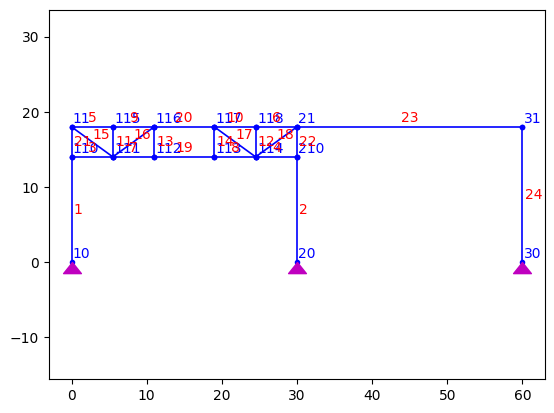

In [ ]:
opsv.plot_model()

<Axes: >

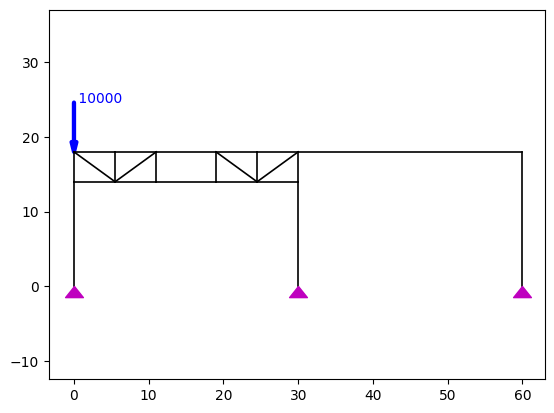

In [ ]:
opsv.plot_load()


In [ ]:
print(ops.nodeDOFs(10))

[-1, -1, 0]
